# Demo of VAE for anomaly detection of diverse sensor data
Trained on non-valve fault data to learn a normal expectation.

Build the model for 512 time points per cycle with 14 sensors.

In [1]:
%matplotlib inline

In [2]:
from demo import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
model = VAE1D(size, n_channels, n_latent)
model = model.to(device)
print(f"Time-series size = {size}, number of sensors = {n_channels}")

Time-series size = 512, number of sensors = 14


Load the best parameters from training.

In [5]:
model = load_checkpoint(model, device)

Checkpoint Performance:
Validation loss: 22.497
Epoch: 71


In [6]:
params = model.demo()

Input size: torch.Size([1, 14, 512])
Encoded size: torch.Size([1, 1024, 4])
Latent size: torch.Size([1, 40, 1])
Decoded (output) size: torch.Size([1, 14, 512])


In [7]:
print(params[0][:, :, :3])
print(params[-1][:, :, :3])

tensor([[[0.8916, 0.3010, 0.8422],
         [0.3559, 0.0761, 0.5382],
         [0.4582, 0.0949, 0.4904],
         [0.9547, 0.2095, 0.4194],
         [0.6701, 0.2436, 0.3782],
         [0.5903, 0.7011, 0.5130],
         [0.4979, 0.1646, 0.0679],
         [0.9852, 0.6384, 0.6077],
         [0.1855, 0.8399, 0.8363],
         [0.0488, 0.0462, 0.7640],
         [0.9269, 0.3107, 0.4306],
         [0.0191, 0.8692, 0.2593],
         [0.1888, 0.7788, 0.4626],
         [0.2635, 0.1582, 0.7100]]], device='cuda:0')
tensor([[[0.6676, 0.5832, 0.3600],
         [0.2620, 0.1053, 0.1586],
         [0.5406, 0.6260, 0.7336],
         [0.4277, 0.6816, 0.5804],
         [0.7154, 0.3422, 0.5332],
         [0.1834, 0.0770, 0.0835],
         [0.5087, 0.3319, 0.2807],
         [0.6733, 0.6861, 0.5488],
         [0.6656, 0.5111, 0.6667],
         [0.2616, 0.3446, 0.2290],
         [0.3782, 0.3437, 0.2922],
         [0.2778, 0.2631, 0.2985],
         [0.4312, 0.3716, 0.4821],
         [0.1031, 0.0749, 0.0845]]],

Next we need to load the datasets of sensors readings.

In [8]:
data_path = Path('data/hydraulic')
train_dl, val_dl, test_dl = load_datasets(data_path)

Let's get some random images from the dataset for examples and generate new versions.

In [62]:
data, targets = get_random_samples(val_dl)

In [65]:
list_target_classes(val_dl)

0 = norm


In [66]:
targets = targets.cpu().numpy()
targets

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [67]:
criterion = VAE1DLoss()
criterion = criterion.to(device)

In [68]:
model.eval()
with torch.no_grad():
    # Generate
    data = data.to(device)
    gen_data, mu, logvar = model(data)
#     loss, loss_desc = criterion(gen_data, data, mu, logvar, reduce=False)
    

In [69]:
gen_err = nn.functional.binary_cross_entropy(gen_data, data,
                                             reduction='mean')

In [72]:
# gen_err[0, :5, :5]
gen_err

tensor(0.5652, device='cuda:0')

[[-0.35259044 -0.31664053 -0.24271779 -0.42535767 -0.28474998]
 [-0.1140099  -0.22600693 -0.24150969 -0.2190222  -0.20099664]
 [-0.3170215  -0.4119242  -0.4710736  -0.4476252  -0.41496325]
 [-0.23113507 -0.30411848 -0.23075029 -0.21441889 -0.19647646]
 [-0.11915416 -0.33424953 -0.51159984 -0.33319217 -0.3280826 ]]
MSE = 578.86279296875


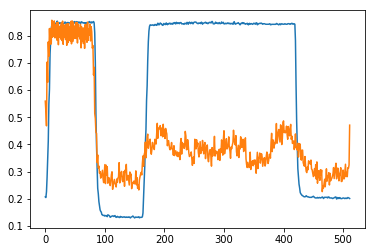

In [73]:
idx = 0
sample = data[idx, :, :].cpu().numpy()
gen_sample = gen_data[idx, :, :].cpu().numpy()
plt.plot(sample[0, :])
plt.plot(gen_sample[0, :])
print(sample[:5, :5] - gen_sample[:5, :5])
print(f"MSE = {np.power((sample - gen_sample), 2).sum() / 2}")

[[-0.23808223 -0.3136304  -0.13661256 -0.3303685  -0.14816415]
 [-0.10092053 -0.18658061 -0.24416265 -0.18313494 -0.1792625 ]
 [ 0.02783716  0.09873798  0.15127426  0.1038579   0.11940768]
 [-0.20489368 -0.24150121 -0.05846006 -0.14222586 -0.01665264]
 [ 0.0009869  -0.3676513  -0.500208   -0.40965348 -0.3847443 ]]
MSE = 54.760093688964844


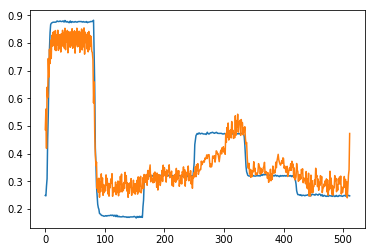

In [74]:
idx = 9
sample = data[idx, :, :].cpu().numpy()
gen_sample = gen_data[idx, :, :].cpu().numpy()
plt.plot(sample[0, :])
plt.plot(gen_sample[0, :])
print(sample[:5, :5] - gen_sample[:5, :5])
print(f"MSE = {np.power((sample - gen_sample), 2).sum() / 2}")

In [75]:
MSE = []
for idx, target in enumerate(targets):
    sample = data[idx, :, :].cpu().numpy()
    gen_sample = gen_data[idx, :, :].cpu().numpy()
    MSE.append(np.power((sample - gen_sample), 2).sum() / 2)
    print(f"Target = {target}, MSE = {MSE[idx]:.3f}")

Target = 0, MSE = 578.863
Target = 0, MSE = 84.357
Target = 0, MSE = 162.446
Target = 0, MSE = 402.326
Target = 0, MSE = 324.838
Target = 0, MSE = 141.625
Target = 0, MSE = 65.511
Target = 0, MSE = 391.252
Target = 0, MSE = 75.402
Target = 0, MSE = 54.760
Target = 0, MSE = 135.444
Target = 0, MSE = 86.763
Target = 0, MSE = 207.569
Target = 0, MSE = 34.517
Target = 0, MSE = 180.403
Target = 0, MSE = 80.004
Target = 0, MSE = 60.985
Target = 0, MSE = 118.398
Target = 0, MSE = 178.710
Target = 0, MSE = 87.541
Target = 0, MSE = 41.153
Target = 0, MSE = 170.115
Target = 0, MSE = 57.586
Target = 0, MSE = 164.999
Target = 0, MSE = 261.768
Target = 0, MSE = 326.906
Target = 0, MSE = 104.416
Target = 0, MSE = 115.312
Target = 0, MSE = 103.831
Target = 0, MSE = 342.839
Target = 0, MSE = 172.373
Target = 0, MSE = 68.728
Target = 0, MSE = 510.457
Target = 0, MSE = 320.370
Target = 0, MSE = 280.064
Target = 0, MSE = 239.846
Target = 0, MSE = 147.660
Target = 0, MSE = 398.609
Target = 0, MSE = 150.39

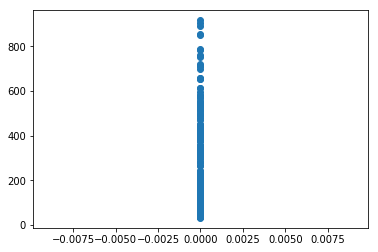

In [76]:
plt.scatter(targets, MSE)

Show the data plots.

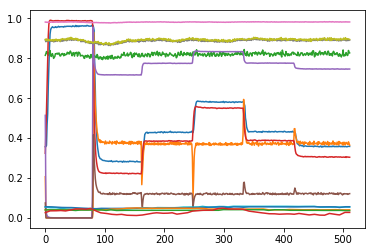

In [77]:
show_plot(sample)

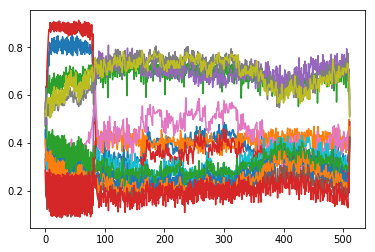

In [78]:
show_plot(gen_sample)

Let's score the success of the recreation and look for outliers.